<img src="graphs.jpg">

# Equipe 
- Álvaro de Araújo
- Rafael Torres

# Problema escolhido

busca do menor caminho entre dois pontos em um mapa



## Algoritmos utilizados
para esse trabalho foram o A* e o Aprofundamento Iterativo

### `A*`
- algoritmo de busca que utiliza heurística para encontrar o caminho mais curto entre dois pontos. Esse algoritmo usa uma funcção que é a soma do custo e da heurística.
    -  A função custo é a distância percorrida pelo grafo do início até aquele determinado ponto.
    -  A heurística é a distância entre o ponto atual e o ponto final. 
    - A soma do custo e da heurística é o valor que o algoritmo utiliza para escolher o próximo ponto a ser visitado, sendo este o ponto com a menor soma.

### `Aprofundamento Iterativo`
- algoritmo de busca que mistura a busca em largura e a busca em profundidade
    - em cada iteração a busca em profundidade aumenta em um nível, dessa forma é possível encontrar o caminho mais curto entre dois pontos de uma forma ótima

# Importar bibliotecas

In [1]:
import pandas as pd
import osmnx as ox

# Extrair grafo das coordenadas

## função para mostrar pontos no mapa

In [2]:
def mostrarPontosNoGrafo(grafo, noInicio, noFim):
    _, ax = ox.plot_graph(grafo, show=False, close=False)
    ax.scatter(grafo.nodes[noInicio]['x'], grafo.nodes[noInicio]['y'], c='red')
    ax.scatter(grafo.nodes[noFim]['x'], grafo.nodes[noFim]['y'], c='red');

## Grafo

In [3]:
noInicio = 900551253
noFim = 8794056279

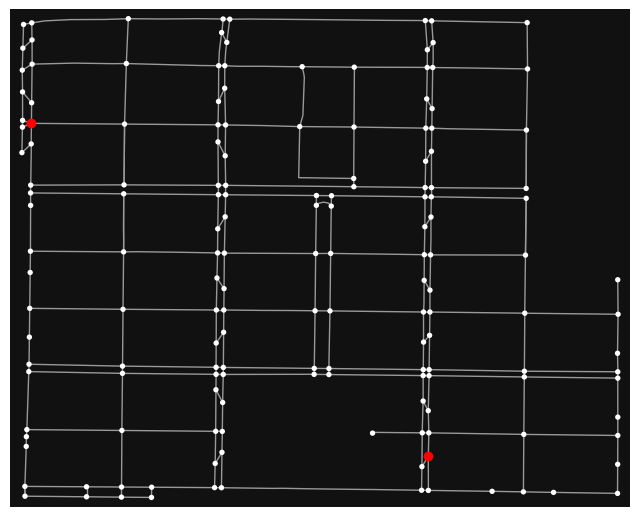

In [4]:
# dados do grafo da área de análise
# é um grafo orientado
grafo_inga = ox.graph_from_bbox(-23.418168, -23.425714, -
                                                 51.943336, -51.933149, network_type='drive')
mostrarPontosNoGrafo(grafo_inga, noInicio, noFim)

# DataFrame
a biblioteca osmnx gera uma matriz com as coordenadas de cada nó do grafo, velocidade da via, nível da via e outros dados. Dessa matriz, foi filtrado os dados que interessam ao problema, que são: os nós, seus vizinhos e as distâncias entre eles. 

In [5]:
def grafoDataFrame(grafo):
    # passar a matriz de adjacência para um dataframe
    df = pd.DataFrame(ox.graph_to_gdfs(grafo, nodes=False))

    # extração dos nós, vizinhos e distância entre eles
    df = pd.DataFrame(df['length']).reset_index().copy()
    
    # exclui coluna que não seria necessária
    df.drop(['key'], axis=1, inplace=True)

    return df

In [6]:
dfGrafo = grafoDataFrame(grafo_inga)

In [7]:
dfGrafo

,u,v,length
0,900551253,1425773167,162.403
1,900551253,2408398027,35.874
2,900551288,8794665935,50.239
3,1416810736,8763493537,55.776
4,1416810736,1421459530,13.040
...,...,...,...
258,8794665933,900551288,32.002
259,8794665935,1421688586,50.728
260,8844181770,1421706657,38.299
261,8844181771,8844181770,21.450


# funções que serão usadas em ambos os algoritmos

In [8]:
from codigo.vertice import Vertice

In [9]:
# distância do vértice de inicio até o vértice atual
def custo(u, v):
    return u.getCusto() + dfGrafo[(dfGrafo['u'] == u.getIdNo()) & (dfGrafo['v'] == v)]['length'].tolist()[0]

In [10]:
def recuperarCaminho(arvore):
    caminho = [arvore[-1].getIdNo()]
    pai = arvore[-1].getPai()
    cont = len(arvore) - 1

    bool = True
    while bool:
        if arvore[cont].getIdNo() == pai:
            caminho.append(arvore[cont].getIdNo())
            pai = arvore[cont].getPai()
        
        if pai == None:
            bool = False

        cont -= 1

    return caminho[::-1], arvore[-1].getCusto()

# A*


In [11]:
# distância em linha reta do vértice atual ao vértice fim
def heuristica(grafo, u, v):
    return ox.distance.great_circle_vec(grafo.nodes[u]['x'], grafo.nodes[u]['y'], grafo.nodes[v]['x'], grafo.nodes[v]['y'], earth_radius=6371009)

In [12]:
def buscaAestrela(grafo, inicio, fim):
    ordenarPeloCusto = lambda encontrarVizinhos: encontrarVizinhos.sort(key=lambda x: x.getCusto() + x.getHeuristica())
    encontrarVizinhos = []
    arvore = []
    nosJaPercorridos = [inicio]  

    encontrarVizinhos.append(Vertice(inicio, None, 0, heuristica(grafo, inicio, fim)))

    while encontrarVizinhos != [] and (arvore[-1].getIdNo() != fim if arvore != [] else True):
        atual = encontrarVizinhos.pop(0)
        arvore.append(atual)

        for adjacente in grafo.adj[atual.getIdNo()]:
            if adjacente not in nosJaPercorridos:
                nosJaPercorridos.insert(0, adjacente)
                encontrarVizinhos.append(Vertice(adjacente, atual.getIdNo(), custo(atual, adjacente), heuristica(grafo, adjacente, fim)))
      
        ordenarPeloCusto(encontrarVizinhos)

    if encontrarVizinhos == []:
        print(f'\n\nnó {fim} não encontrado\n\n')

    return arvore

In [13]:
arvore = buscaAestrela(grafo_inga, noInicio, noFim)

# Visualizar rota

In [14]:
def mostrarCaminho():
    caminho, custo = recuperarCaminho(arvore)
    print(f'Custo: ', round(custo, 2), 'm')

    ox.plot.plot_graph_route(grafo_inga, caminho);


Custo:  1272.78 m


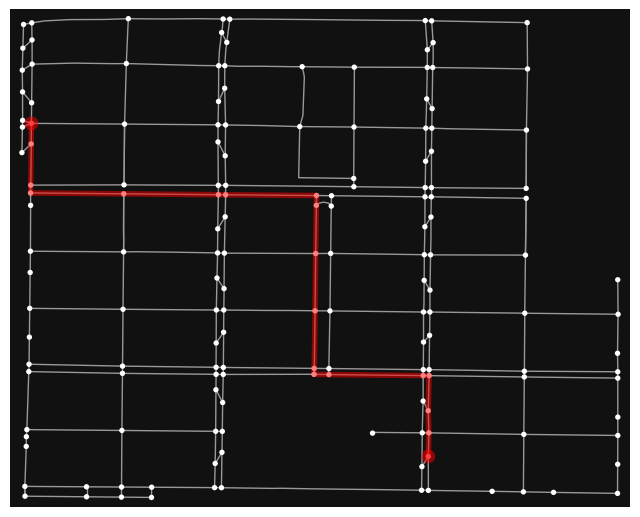

In [15]:
mostrarCaminho()

# Aprofundamento Iterativo

In [16]:
def buscaAprofundamentoIterativo(grafo, inicio, fim, profundidade):
   arvore = []
   listaAdjacencia = [Vertice(inicio, None, 0, profundidade=0)]
   nosJaPercorridos = [inicio]   


   while listaAdjacencia != [] and (arvore[-1].getIdNo() != fim if arvore != [] else True):
      vertice = listaAdjacencia.pop(0)
      arvore.append(vertice)

      if vertice.getProfundidade() < profundidade:
         for adjacente in grafo.adj[vertice.getIdNo()]:
            if adjacente not in nosJaPercorridos:
               nosJaPercorridos.insert(0, adjacente)
               listaAdjacencia.append(Vertice(adjacente, vertice.getIdNo(), custo(vertice, adjacente), profundidade=vertice.getProfundidade() + 1))


   encontrou = True if arvore[-1].getIdNo() == fim else False

   return arvore, encontrou


In [17]:
profundidade = 0
encontrou = False

while encontrou == False:
    arvore, encontrou = buscaAprofundamentoIterativo(grafo_inga, noInicio, noFim, profundidade)
    profundidade += 1

Custo:  1264.76 m


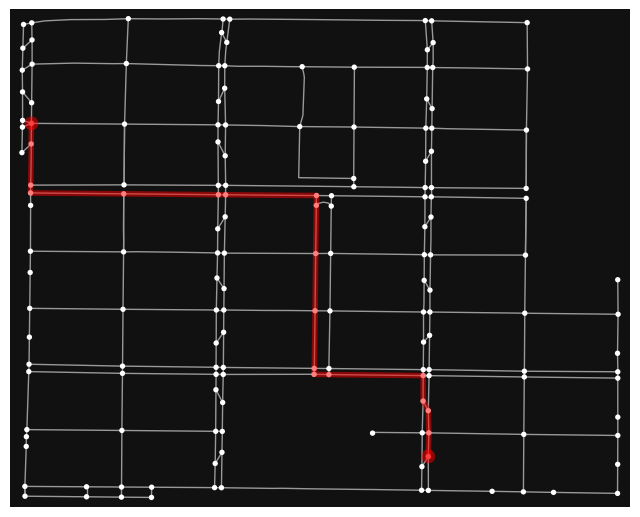

In [18]:
mostrarCaminho()

# Conclusão
O algoritmo A* consegue achar um caminho mais curto em um tempo significativamente menor que o Aprofundamento Iterativo. Quando o gráfo é pequeno os dois possuem resultados similares. Mas a medida que o grafo aumenta, o A* consegue achar o caminho mais curto em um tempo menor.

# Bibliografia
- material do professor
- https://www.geeksforgeeks.org/a-search-algorithm/
- https://www.youtube.com/watch?v=-qj-9bvwh2Y
- https://www.youtube.com/watch?v=UwtjG1BUHJA&t=332s